## Prueba Optuna SVM

In [1]:
import optuna

# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor

# Metemos un gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from collections import Counter
from sklearn.impute import SimpleImputer
import optuna


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile

# Según el criterio chi-squared dustribution for it to have three features
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest


# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [2]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

In [3]:
## ENCODING

df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30']) 

#### Preprocesamiento

In [4]:
## PREPROCESAMIENTO

np.random.seed(1234)

df_train = df_train_encoded
df_test = df_test_encoded

# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()

<Axes: xlabel='column', ylabel='value'>

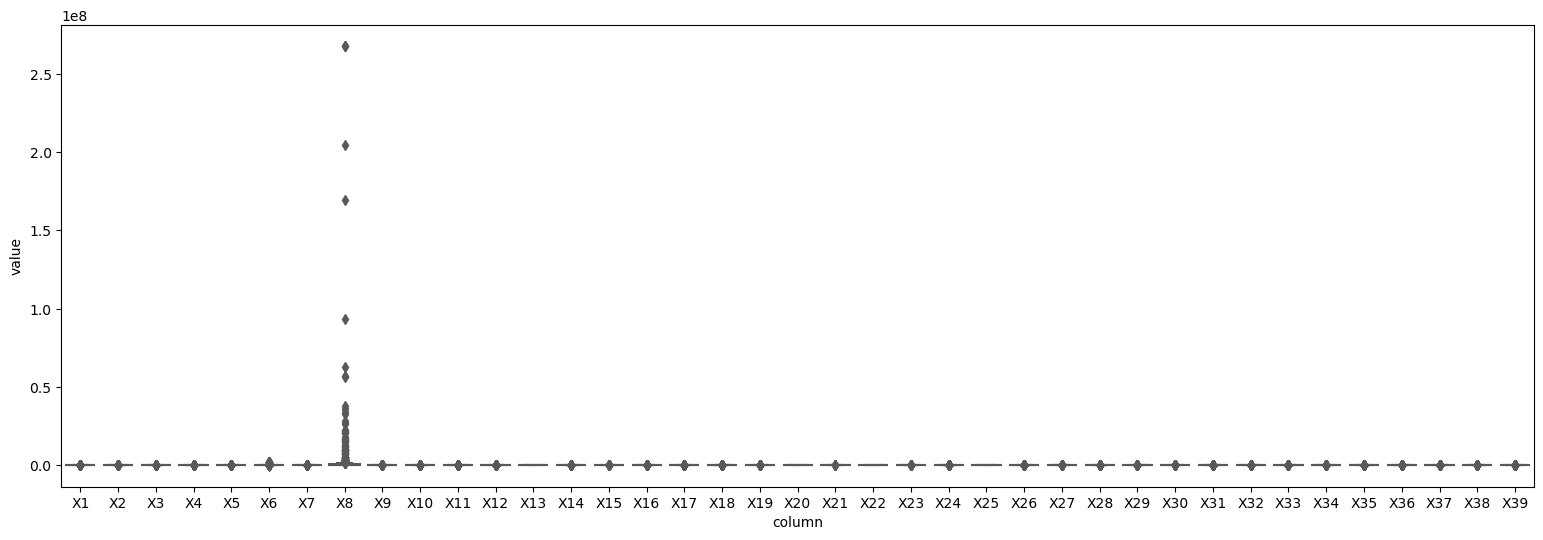

In [5]:
df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

# Escala logarítmica a las que se dispersan mucho
# df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
# df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(19,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [6]:
#1. Quitar outliers

modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na = df_train_copy.dropna(axis=0, inplace=False)

modelo_isof.fit(X=df_no_na)
clasificacion_predicha = modelo_isof.predict(X=df_no_na)
clasificacion_predicha

df_no_na['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na.index[df_no_na['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers = df_train_copy.drop(index=indices_outliers)

# Ahora, imputo sobre el dataset sin outliers
# imp_train = KNNImputer(n_neighbors=5).fit(df_no_outliers)
# df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

imp_train = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers) #most_frequent
df_train_imp = pd.DataFrame(imp_train.transform(df_train_copy), columns=df_train_copy.columns, index=df_train_copy.index)

# Hago lo mismo para test

modelo_isof_test = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                n_jobs        = -1,
                random_state  = 123,
            )

df_no_na_test = df_test_copy.dropna(axis=0, inplace=False)

modelo_isof_test.fit(X=df_no_na_test)
clasificacion_predicha = modelo_isof_test.predict(X=df_no_na_test)
clasificacion_predicha

df_no_na_test['clasificacion_predicha'] = clasificacion_predicha
indices_outliers = df_no_na_test.index[df_no_na_test['clasificacion_predicha'] == -1].tolist()

indices_outliers

df_no_outliers_test = df_test_copy.drop(index=indices_outliers)

# imp_test = KNNImputer(n_neighbors=5).fit(df_no_outliers_test)
# df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

#Imputamos con mediana

imp_test = SimpleImputer(missing_values=np.nan, strategy='median').fit(df_no_outliers_test)
df_test_imp = pd.DataFrame(imp_test.transform(df_test_copy), columns=df_test_copy.columns, index=df_test_copy.index)

In [7]:
# # 4. Escalamos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
df_scaled = pd.DataFrame(df_scaled,index=df_train_imp.index, columns=[df_train_imp.columns])

df_scaled_test = scaler.transform(df_test_imp.to_numpy())
df_scaled_test = pd.DataFrame(df_scaled_test,index=df_test_imp.index, columns=[df_test_imp.columns])

# # 5. Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_scaled_test, left_index=True, right_index=True)
result_df_test.columns = columns

##### Aplicación de Optuna

In [8]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Crea y entrena el modelo SVM
    classifier_obj = svm.SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)
    classifier_obj.fit(X_train, y_train)

    # Evalúa el modelo
    y_pred = classifier_obj.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [9]:
# Crea el estudio y optimiza
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10, show_progress_bar = True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = svm.SVC(**best_trial.params)
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-11 02:36:29,181] A new study created in memory with name: no-name-b97469c2-490b-4c60-b77e-0472a0bc2973


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-11 02:36:29,236] Trial 0 finished with value: 0.6470588235294118 and parameters: {'C': 191.8514809606202, 'gamma': 0.0019159671180753342, 'kernel': 'rbf', 'degree': 5, 'shrinking': False, 'coef0': 9.204143773301453, 'class_weight': None}. Best is trial 0 with value: 0.6470588235294118.
[I 2024-01-11 02:36:29,510] Trial 1 finished with value: 0.6654411764705882 and parameters: {'C': 15.001981270232958, 'gamma': 0.6455605701529084, 'kernel': 'linear', 'degree': 8, 'shrinking': True, 'coef0': 7.763093863222944, 'class_weight': None}. Best is trial 1 with value: 0.6654411764705882.
[I 2024-01-11 02:36:29,543] Trial 2 finished with value: 0.4007352941176471 and parameters: {'C': 0.13191245311416067, 'gamma': 5.12548760588023, 'kernel': 'sigmoid', 'degree': 7, 'shrinking': False, 'coef0': 5.724846480358, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.6654411764705882.
[I 2024-01-11 02:36:29,613] Trial 3 finished with value: 0.47794117647058826 and parameters: {'C': 106

In [10]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_optuna.csv', index=False, sep=',')